In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
listings = pd.read_csv('listings.csv')

In [3]:
# removes columns which I don't believe will be predictors such as ids and urls, removes null values from weekly price, populate null values in columns with mean and modes,
# and change value types from string to float or string to boolean
def clean_data(listings):
    listings = listings.drop(
        ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered',
         'neighborhood_overview',
         'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_thumbnail_url',
         'host_about', 'host_url', 'host_name', 'host_id', 'first_review', 'last_review', 'calendar_last_scraped', 'street', 'host_verifications', 'price', 'amenities', 'host_picture_url'], axis=1)

    drop_predict = listings.dropna(subset=['weekly_price'], axis=0)
    loads = drop_predict.columns[np.sum(listings.isnull()) / listings.shape[0] > 0.5].tolist()
    clean_df = drop_predict.drop(loads, axis=1)
    category_columns = drop_predict.select_dtypes(include=['object']).columns.tolist()
    integer_columns = drop_predict.select_dtypes(include=['number']).columns.tolist()

    for column in clean_df:
        if isinstance(clean_df[[column]].iloc[0][0], str) and '$' in clean_df[[column]].iloc[0][0] :
            clean_df[column] = clean_df[column].str.replace('$','').str.replace(',','').astype(float)
        elif isinstance(clean_df[[column]].iloc[0][0], str) and '%' in clean_df[[column]].iloc[0][0]:
            clean_df[column] = clean_df[column].str.replace('%', '').astype(float)
        elif isinstance(clean_df[[column]].iloc[0][0], str) and clean_df[[column]].iloc[0][0] in ['t','f']:
            clean_df[column] = clean_df[column].str.replace('t', 'True').str.replace('f', 'False').astype(bool)
        elif isinstance(clean_df[[column]].iloc[0][0], str) and '-' in clean_df[[column]].iloc[0][0] and len(clean_df[[column]].iloc[0][0])==10:
            clean_df[column] = pd.to_datetime(clean_df[column])
            clean_df[column]=(pd.Timestamp.now() - clean_df[column]).dt.days

        if clean_df[column].isnull().any():
            if (column in category_columns):
                clean_df[column] = clean_df[column].fillna(clean_df[column].mode()[0])
            elif (column in integer_columns):
                clean_df[column] = clean_df[column].fillna(clean_df[column].mean())

    return clean_df

In [4]:
clean_listings=clean_data(listings)
clean_listings.head(5)

/var/folders/p3/hcxmz1ws7hj2plm2hx190sx00000gp/T/ipykernel_89242/1102937815.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  clean_df[column] = clean_df[column].str.replace('$','').str.replace(',','').astype(float)
/var/folders/p3/hcxmz1ws7hj2plm2hx190sx00000gp/T/ipykernel_89242/1102937815.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  clean_df[column] = clean_df[column].str.replace('$','').str.replace(',','').astype(float)
/var/folders/p3/hcxmz1ws7hj2plm2hx190sx00000gp/T/ipykernel_89242/1102937815.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treat

,id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,...,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1,953595,3953.0,"Seattle, Washington, United States",within an hour,98.0,100.0,True,Queen Anne,6.0,6.0,...,10.00000,10.000000,True,WASHINGTON,True,strict,True,True,6,1.480000
3,7421966,3695.0,"Seattle, Washington, United States",within an hour,100.0,100.0,True,Queen Anne,1.0,1.0,...,9.58557,9.471181,True,WASHINGTON,True,flexible,True,True,1,2.016972
5,5956968,4742.0,"Seattle, Washington, United States",within an hour,100.0,100.0,True,Queen Anne,1.0,1.0,...,10.00000,10.000000,True,WASHINGTON,True,strict,True,True,1,2.450000
6,1909058,4220.0,"Seattle, Washington, United States",within an hour,100.0,100.0,True,Queen Anne,1.0,1.0,...,10.00000,10.000000,True,WASHINGTON,True,moderate,True,True,1,2.460000
7,856550,4067.0,"Seattle, Washington, United States",within an hour,100.0,100.0,True,Queen Anne,5.0,5.0,...,9.00000,10.000000,True,WASHINGTON,True,strict,True,True,5,4.730000


In [5]:
# plot graphs of neighbourhoods
def make_neighbourhood_graphs(data, heading, x_label, y_label, index_bool):
    if index_bool:
        data.set_index('index', inplace=index_bool)
    data.rename(columns={'index': 'Neighbourhood', 'neighbourhood':'count'}, inplace=True)
    data.plot(kind='bar', legend=None)
    plt.title(heading)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.tight_layout()
    plt.show()

/var/folders/p3/hcxmz1ws7hj2plm2hx190sx00000gp/T/ipykernel_89242/1078752019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'index': 'Neighbourhood', 'neighbourhood':'count'}, inplace=True)


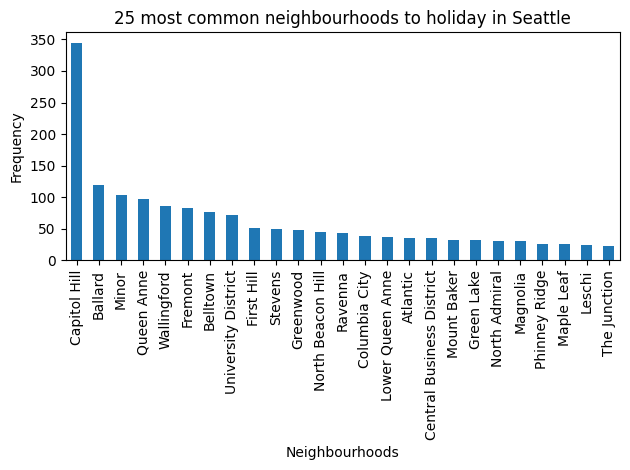

In [7]:
# Which neighbourhood is the most popular to host an airbnb?
# plot the frequency of neighbourhoods
plotdata = clean_listings['neighbourhood'].value_counts().reset_index()
title = '25 most common neighbourhoods to holiday in Seattle'
y = 'Frequency'
x = 'Neighbourhoods'
data_capped = plotdata[:25]
make_neighbourhood_graphs(data_capped, title, x, y, True)

In [8]:
calendar = pd.read_csv('calendar.csv')
calendar

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
...,...,...,...,...
1393565,10208623,2016-12-29,f,NaN
1393566,10208623,2016-12-30,f,NaN
1393567,10208623,2016-12-31,f,NaN
1393568,10208623,2017-01-01,f,NaN


In [9]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [10]:
merge_data = clean_listings.merge(calendar, how='left', left_on='id', right_on='listing_id')

In [11]:
seasonality_prep = merge_data[merge_data['available']=='t'][['host_neighbourhood','date']]
seasonality_prep['month'] = [ datetime.datetime.strptime(d, '%Y-%m-%d').month for d in seasonality_prep['date'] ]

In [12]:
seasonality_prep['month']

0         1
1         1
5         1
6         1
7         1
         ..
733004    3
733005    3
733006    3
733007    3
733008    4
Name: month, Length: 504763, dtype: int64

KeyboardInterrupt: 

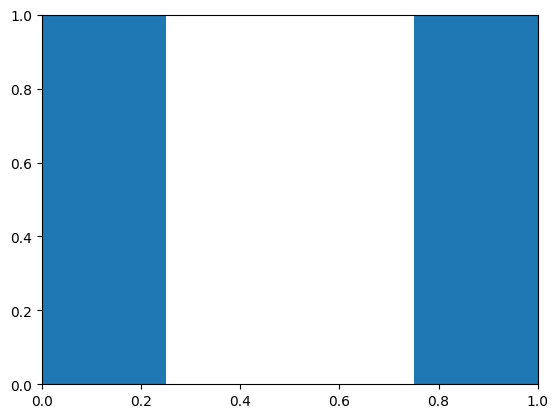

In [13]:
# FIX ME!

plotdata = seasonality_prep['month'].reset_index()
title = 'Most common months for properties to be booked'
y = 'Frequency'
x = 'Month'
plotdata.set_index('index', inplace=True)
plotdata.rename(columns={'index': 'Month', 'month':'count'}, inplace=True)
# plotdata.plot(kind='bar', legend=None)
# plt.title(heading)
# plt.ylabel(y_label)
# plt.xlabel(x_label)
# plt.tight_layout()
# plt.show()

In [25]:
seasonality_prep['month']

,host_neighbourhood,date,month
0,Queen Anne,2016-01-04,1
1,Queen Anne,2016-01-05,1
5,Queen Anne,2016-01-09,1
6,Queen Anne,2016-01-10,1
7,Queen Anne,2016-01-11,1
...,...,...,...
733004,Capitol Hill,2016-03-28,3
733005,Capitol Hill,2016-03-29,3
733006,Capitol Hill,2016-03-30,3
733007,Capitol Hill,2016-03-31,3


In [24]:
plotdata = seasonality_prep['month'].reset_index()
plotdata

,index,month
0,0,1
1,1,1
2,5,1
3,6,1
4,7,1
...,...,...
504758,733004,3
504759,733005,3
504760,733006,3
504761,733007,3


In [16]:
title = 'Most common months for properties to be booked'


In [17]:
y = 'Frequency'
x = 'Month'

In [23]:
plotdata.set_index('month', inplace=True)
plotdata

""
month
1
1
1
1
1
...
3
3
3
